### Importing Dependencies


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import sklearn
import os, pathlib
import kaggle, kagglehub


### Downloading the competition


In [2]:
competition_name = (
    "playground-series-s5e1"  # Change this to the competition you want to download
)
competition_path = pathlib.Path(
    kagglehub.competition.competition_download(competition_name)
)  # Downloads the competition
competition_files: list = os.listdir(
    competition_path
)  # List of the files included in the competition

print(competition_files)

['sample_submission.csv', 'test.csv', 'train.csv']


In [53]:
pl.Config.set_tbl_rows(40)  # polars config set number of rows to display

train_df = pl.read_csv(competition_path / "train.csv")
test_df = pl.read_csv(competition_path / "test.csv")
sample_submission_df = pl.read_csv(competition_path / "sample_submission.csv")

test_df = test_df.with_columns(pl.lit(None).alias("num_sold"))

train_last_row = train_df[-1]
test_first_row = test_df[0]

In [54]:
df = pl.concat([train_df, test_df]).with_columns(
    [
        pl.col("id").cast(pl.UInt32),
        pl.col("date").cast(pl.Date),
        pl.col("country").cast(pl.Categorical),
        pl.col("store").cast(pl.Categorical),
        pl.col("product").cast(pl.Categorical),
        pl.col("num_sold").cast(pl.UInt16),
    ]
)

In [55]:
df

id,date,country,store,product,num_sold
u32,date,cat,cat,cat,u16
0,2010-01-01,"""Canada""","""Discount Stickers""","""Holographic Goose""",null
1,2010-01-01,"""Canada""","""Discount Stickers""","""Kaggle""",973
2,2010-01-01,"""Canada""","""Discount Stickers""","""Kaggle Tiers""",906
3,2010-01-01,"""Canada""","""Discount Stickers""","""Kerneler""",423
4,2010-01-01,"""Canada""","""Discount Stickers""","""Kerneler Dark Mode""",491
5,2010-01-01,"""Canada""","""Stickers for Less""","""Holographic Goose""",300
6,2010-01-01,"""Canada""","""Stickers for Less""","""Kaggle""",1837
7,2010-01-01,"""Canada""","""Stickers for Less""","""Kaggle Tiers""",1659
8,2010-01-01,"""Canada""","""Stickers for Less""","""Kerneler""",807


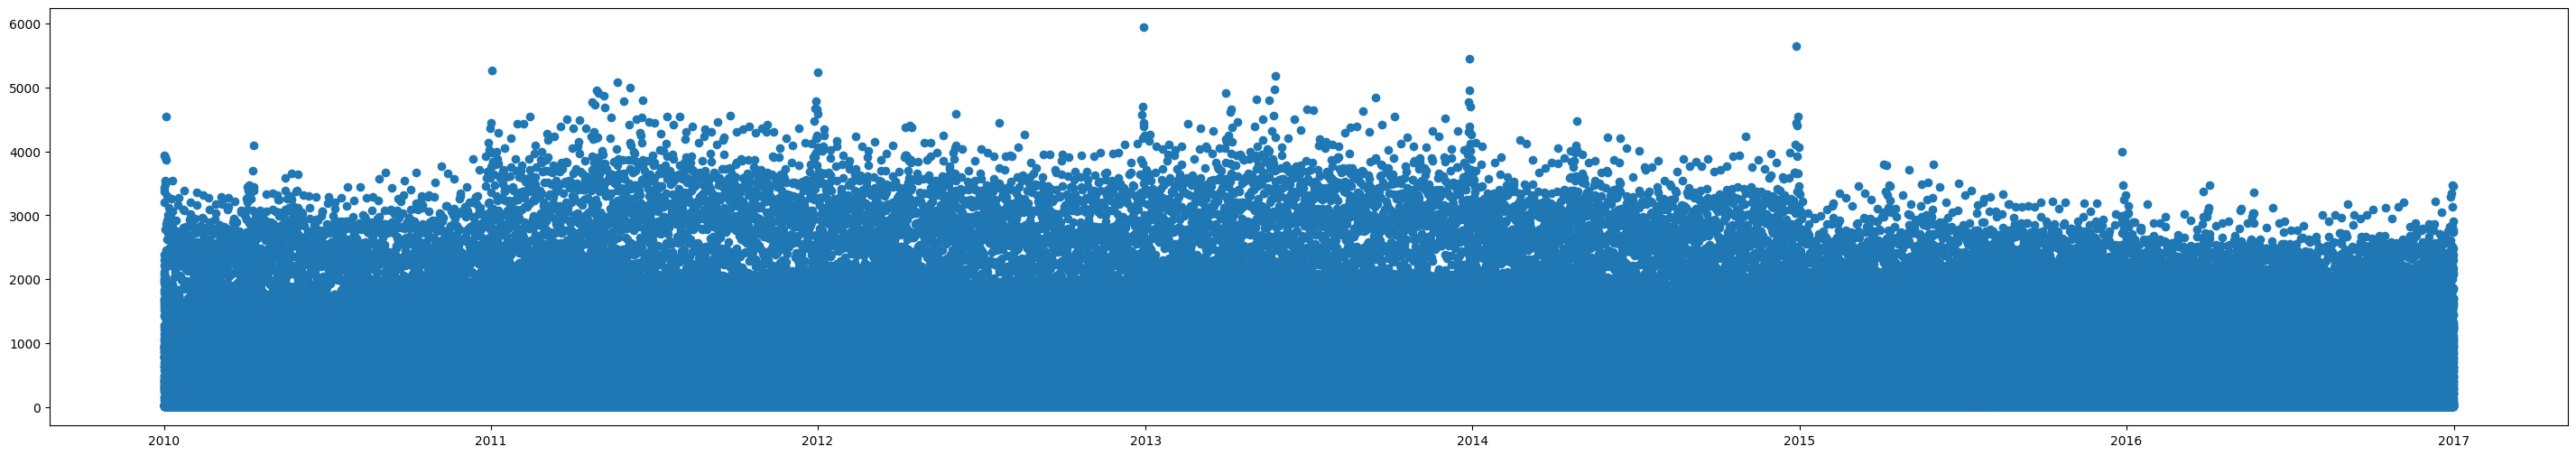

In [56]:
plt.figure(figsize=(36, 6))
plt.scatter(df['date'], df['num_sold'])

In [61]:
new_df = pl.concat(
    [df,
     df['country'].to_dummies(),
     df['store'].to_dummies(),
     df['product'].to_dummies()],
    how='horizontal')



In [73]:
date_encoded_df = new_df.with_columns([
    ((pl.col('date').dt.year() - 2009) / 10).alias('year'),
    (np.sin(2 * np.pi * pl.col("date").dt.month() / 12)).alias("month_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.day() / 31)).alias("day_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.weekday() / 7)).alias("weekday_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.ordinal_day() / 366)).alias("ordinal_day_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.week() / 53)).alias("week_sin")
])

In [75]:
date_encoded_df.write_parquet('./exported_df.parquet')